Proyek Pertama<br>
Kelas Machine Learning Terapan<br>
Ellion Blessan<br>
Analisis Sentimen Aplikasi by.U

# Data preparation
Data diperoleh melalui scraping user review aplikasi by.U di Google Play Store menggunakan package google-play-scraper.

In [1]:
pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mengimpor dependencies

In [2]:
from google_play_scraper import Sort, reviews, app
import pandas as pd
 
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

Data yang diambil adalah review berbahasa Indonesia dan berasal dari Negara Indoneisa

In [3]:
app_package = 'com.byu.id'
app_reviews = []

for score in list(range(1, 6)):
  for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
    rvs, _ = reviews(
      app_package,
      lang='id',
      country='id',
      sort=sort_order,
      count= 10000
    )
    for r in rvs:
      r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
      r['appId'] = app_package
    app_reviews.extend(rvs)

Pembuatan dataframe dari data hasil scraping

In [4]:
df = pd.DataFrame(app_reviews)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              100000 non-null  object        
 1   userName              100000 non-null  object        
 2   userImage             100000 non-null  object        
 3   content               100000 non-null  object        
 4   score                 100000 non-null  int64         
 5   thumbsUpCount         100000 non-null  int64         
 6   reviewCreatedVersion  85330 non-null   object        
 7   at                    100000 non-null  datetime64[ns]
 8   replyContent          97980 non-null   object        
 9   repliedAt             97980 non-null   datetime64[ns]
 10  sortOrder             100000 non-null  object        
 11  appId                 100000 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 9.2

Drop fitur yang tidak dipakai

In [5]:
df = df.loc[:, ['content','score']]
df.head()

,content,score
0,Udah pakai byu 1thn dan setiap bulan bisa meng...,1
1,"Tolong dong Jgn dipake FUP nya, membuat pelang...",1
2,Dapat gangguan terkait paket yang sudah dibeli...,1
3,Aturan fup baru untuk paket unlimite 2mbps san...,1
4,Aturan fup baru untuk paket unlimite 2mbps san...,1


# Data exploration
Diperoleh 100,000 baris data, dengan kolom content berisi kalimat review dan kolom score berisi jumlah bintang yang diberikan.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  100000 non-null  object
 1   score    100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


Jumlah data komentar tiap score

In [7]:
df.score.value_counts()

1    50785
5    24375
2     9125
3     8660
4     7055
Name: score, dtype: int64

Pemisahan dataframe menjadi dua, data berlabel dan tidak berlabel

In [8]:
labeled_df = pd.concat([df[df.score==1], df[df.score==5]])
unlabeled_df = pd.concat([df[df.score==2], df[df.score==3], df[df.score==4]])
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75160 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  75160 non-null  object
 1   score    75160 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


Dilakukan pelabelan manual pada data dengan score 1 dan 5. Diasumsikan data dengan score 1 berlabel negative, sedangkan data dengan score 5 berlabel positive

In [9]:
labeled_df.score[labeled_df.score==1] = 'negative'
labeled_df.score[labeled_df.score==5] = 'positive'
labeled_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,content,score
0,Udah pakai byu 1thn dan setiap bulan bisa meng...,negative
1,"Tolong dong Jgn dipake FUP nya, membuat pelang...",negative
2,Dapat gangguan terkait paket yang sudah dibeli...,negative
3,Aturan fup baru untuk paket unlimite 2mbps san...,negative
4,Aturan fup baru untuk paket unlimite 2mbps san...,negative


Jumlah data per label

In [10]:
labeled_df.value_counts('score')

score
negative    50785
positive    24375
dtype: int64

Bar chart mengenai jumlah data per score

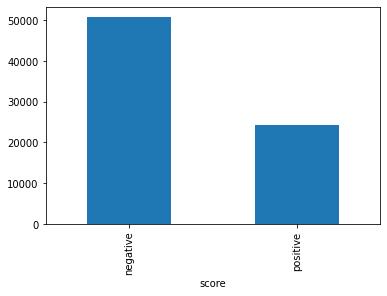

In [11]:
labeled_df.groupby('score').size().plot(kind='bar')

Histogram sebaran panjang karakter dari setiap data komentar

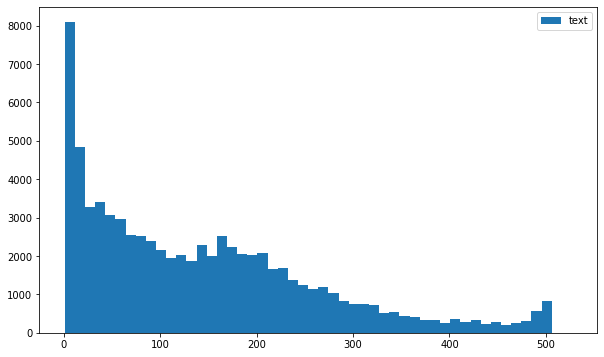

In [12]:
length = labeled_df['content'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length, bins=50, label='text')
plt.legend()

Wordcloud dari data komentar berlabel

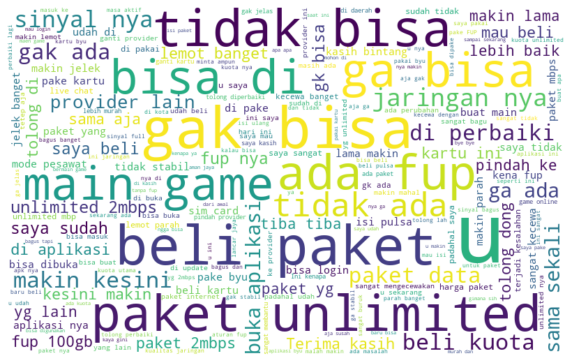

In [13]:
def wordCloud(words):
  wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)  
  plt.figure(figsize=(10, 7))
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.axis('off')
 
all_words = ' '.join([text for text in labeled_df['content']])
wordCloud(all_words)

# Data pre-processing
Data berlabel dibagi menjadi data train dan data test, serta dilakukan vektorisasi.

Data komentar menjadi fitur yang akan diukur, dan label menjadi target dalam pelatihan

In [14]:
X = labeled_df['content']
y = labeled_df['score']

Train-test-split dengan data test sebesar 20% dari total data berlabel

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21112022)

Vektorisasi menggunakan TF-IDF vectorizer

In [16]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

# Modeling
Digunakan 3 model klasifikasi yang berbeda: Naive Bayes, SVM, dan KNN. Ketiga model akan dibandingkan untuk mencari model yang paling akurat dalam mengklasifikasikan sentimen.

Algoritma Multinomial Naive Bayes

In [17]:
nb = MultinomialNB()
nb.fit(train_vectors, y_train)
pred_nb = nb.predict(test_vectors)

Algoritma SVM dengan kernel linear

In [18]:
svc = svm.SVC(kernel='linear')
svc.fit(train_vectors, y_train)
pred_svc = svc.predict(test_vectors)

Algoritma KNN dengan jumlah neighbor 10

In [19]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_vectors, y_train)
pred_knn = knn.predict(test_vectors)

# Evaluation
Perbandingan ketiga model berdasarkan metrik presisi, recall, dan akurasi.

Metrik disesuaikan dengan kelas data yang ada

In [20]:
target_names = ['positive', 'negative']

Metrik klasifikasi model Naive Bayes

In [21]:
print('Naive Bayes')
print(classification_report(y_test, pred_nb, target_names=target_names))

Naive Bayes
              precision    recall  f1-score   support

    positive       0.90      0.99      0.94     10047
    negative       0.97      0.78      0.87      4985

    accuracy                           0.92     15032
   macro avg       0.94      0.88      0.90     15032
weighted avg       0.92      0.92      0.92     15032



Metrik klasifikasi model SVM dengan kernel linear

In [22]:
print('SVM')
print(classification_report(y_test, pred_svc, target_names=target_names))

SVM
              precision    recall  f1-score   support

    positive       0.97      0.99      0.98     10047
    negative       0.97      0.95      0.96      4985

    accuracy                           0.97     15032
   macro avg       0.97      0.97      0.97     15032
weighted avg       0.97      0.97      0.97     15032



Metrik klasifikasi model KNN dengan jumlah neighbor 10

In [23]:
print('KNN')
print(classification_report(y_test, pred_knn, target_names=target_names))

KNN
              precision    recall  f1-score   support

    positive       0.99      0.74      0.84     10047
    negative       0.65      0.98      0.78      4985

    accuracy                           0.82     15032
   macro avg       0.82      0.86      0.81     15032
weighted avg       0.87      0.82      0.82     15032



# Prediksi sentimen
Data dengan score 2-4 diprediksi sentimennya menggunakan SVM yang lebih unggul dari model lainnya.

In [24]:
for i in unlabeled_df.index:
  text = vectorizer.transform([unlabeled_df['content'][i]])
  label = svc.predict(text)
  unlabeled_df['score'][i] = label[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Contoh hasil prediksi model terhadap data tanpa label

In [25]:
unlabeled_df.head()

,content,score
10,"Maaf harus kasih rating yg kurang memuaskan, k...",negative
32,Hanya masih terkecewakan dengan problem lama. ...,negative
37,"Paket unlimited 2mbps skrg kurang memuaskan, u...",negative
50,Tolong by.u sinyal nya diapain biar ga lag di ...,negative
51,Admin tolong masalah jaringan di tingkatan lag...,negative


Jumlah prediksi data tanpa label

In [26]:
unlabeled_df.value_counts('score')

score
negative    16350
positive     8490
dtype: int64

Penggabungan data berlabel dengan data tanpa label yang telah diprediksi

In [27]:
total_df = pd.concat([labeled_df, unlabeled_df])
total_df.head()

,content,score
0,Udah pakai byu 1thn dan setiap bulan bisa meng...,negative
1,"Tolong dong Jgn dipake FUP nya, membuat pelang...",negative
2,Dapat gangguan terkait paket yang sudah dibeli...,negative
3,Aturan fup baru untuk paket unlimite 2mbps san...,negative
4,Aturan fup baru untuk paket unlimite 2mbps san...,negative


Jumlah data keseluruhan per label

In [28]:
total_df.value_counts('score')

score
negative    67135
positive    32865
dtype: int64

Analisis sentimen menunjukkan bahwa pengguna aplikasi by.U cenderung memiliki sentimen negatif terhadap aplikasi.

Sebaran sentimen dalam keseluruhan data

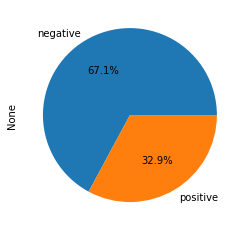

In [29]:
total_df.groupby('score').size().plot(kind='pie', autopct='%1.1f%%')

Wordcloud dari data review yang bersentimen negatif.

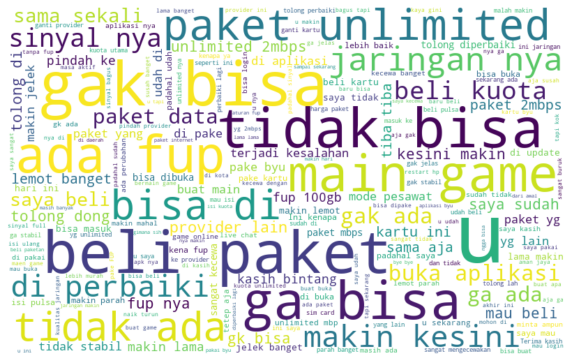

In [30]:
negative_words = ' '.join(text for text in total_df['content'][total_df['score'] == 'negative']) 
wordCloud(negative_words)